# Sentiment Analysis Part 2

## Amazon Kindle Reviews

By Noha Lakhdimi and Jihane Fettoukh

## Contents

1. Final Preprocessing and Feature Selection
2. Tokenization & Sequences
3. Preparing Numerical Features
4. Dataset Splitting
5. Additional Preprocessing Steps

## Final Preprocessing and Feature Selection

After completing the exploratory analysis, several preprocessing steps were applied to prepare the dataset for deep learning.  

For modeling purposes, only features directly relevant to sentiment prediction were retained: the cleaned review text, the sentiment label, and helpfulness-related features. In particular, `helpful_ratio` was used to capture perceived review usefulness, and an additional binary feature (`has_helpful_votes`) was introduced to distinguish between reviews with no votes and those explicitly marked as unhelpful.

All other metadata (e.g., product identifiers, reviewer information, timestamps, and raw star ratings) were excluded to avoid information leakage and reduce input complexity.

In [23]:
import pandas as pd
import numpy as np
import ast
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pickle

In [24]:
# Load the dataset and preview the first 5 rows

df = pd.read_csv('/kaggle/input/kindle-reviews-cleaned/kindle_reviews_cleaned.csv')
df.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,helpful_ratio,Year,sentiment
0,B000F83SZQ,"[0, 0]",5,enjoy vintage book movies enjoy read book plot...,2014-05-05,A1F6404F1VG29J,0.0,2014,1
1,B000F83SZQ,"[2, 2]",4,book reissue old one author bear era say nero ...,2014-01-06,AN0N05A9LIJEQ,1.0,2014,1
2,B000F83SZQ,"[2, 2]",4,fairly interest read old style terminologyi gl...,2014-04-04,A795DMNCJILA6,1.0,2014,1
3,B000F83SZQ,"[1, 1]",5,id never read amy brewster mysteries one reall...,2014-02-19,A1FV0SX13TWVXQ,1.0,2014,1
4,B000F83SZQ,"[0, 1]",4,like period piece clothe lingo enjoy mystery a...,2014-03-19,A3SPTOKDG7WBLN,0.0,2014,1


In [25]:
# Check if any missing values are left from the reviewtext preprocessing

missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)

Missing values per column:
 asin             0
helpful          0
overall          0
reviewText       7
reviewTime       0
reviewerID       0
helpful_ratio    0
Year             0
sentiment        0
dtype: int64


In [26]:
# Drop the rows where there are no reviews

df.dropna(subset = ['reviewText'], inplace = True)

In [27]:
# Check if any missing values are left from the reviewtext preprocessing

missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)

Missing values per column:
 asin             0
helpful          0
overall          0
reviewText       0
reviewTime       0
reviewerID       0
helpful_ratio    0
Year             0
sentiment        0
dtype: int64


> **Note:**
>
> The `helpful_ratio` feature alone cannot distinguish between reviews with no helpfulness votes and reviews that received votes but were deemed unhelpful.  
> To address this ambiguity, we include an additional feature capturing vote presence (or total votes), allowing the model to differentiate between lack of information and negative usefulness feedback.

In [28]:
# Create a binary feature indicating whether a review received any helpfulness votes (denominator > 0)

df['has_helpful_votes'] = df['helpful'].apply(
    lambda x: ast.literal_eval(x)[1] > 0 if pd.notnull(x) else False
)
df[['has_helpful_votes']].describe()

,has_helpful_votes
count,982590
unique,2
top,False
freq,530316


In [29]:
# Keep only the text, target label, and helpfulness information

df_model = df[['reviewText', 'sentiment', 'helpful_ratio', 'has_helpful_votes']].copy()
df_model.head(10)

,reviewText,sentiment,helpful_ratio,has_helpful_votes
0,enjoy vintage book movies enjoy read book plot...,1,0.0,False
1,book reissue old one author bear era say nero ...,1,1.0,True
2,fairly interest read old style terminologyi gl...,1,1.0,True
3,id never read amy brewster mysteries one reall...,1,1.0,True
4,like period piece clothe lingo enjoy mystery a...,1,0.0,True
5,beautiful indepth character description make l...,1,0.0,False
6,enjoy one tho im not sure call amy brewster my...,1,0.0,False
7,never hear amy brewster but dont need like amy...,1,1.0,True
8,darth maul work cloak darkness commit sabotage...,1,0.0,False
9,short story focus darth maul role help trade f...,1,0.0,False


## Tokenization & Sequences

Before training the ANN, the textual data was transformed into a numerical format suitable for neural networks. **Tokenization** was applied to map each unique word to an integer index, enabling the model to learn word representations through embeddings.

To ensure computational efficiency and a consistent input shape, all sequences were **padded or truncated to a fixed maximum length of 400 tokens**. This limit preserves most of the contextual information while preventing excessively long reviews from dominating training time and memory usage.

Additionally, the **vocabulary size was limited to the 50,000 most frequent words**, with out-of-vocabulary terms mapped to a special `<OOV>` token. This improves model robustness, reduces noise from rare words, and helps generalization on unseen data.


In [30]:
# Define the maximum vocabulary size (top 50,000 most frequent words)
# and the maximum sequence length (400 tokens per review)
MAX_WORDS = 50000
MAX_LEN = 400

# Initialize the tokenizer:
# - num_words limits the vocabulary to the most frequent words
# - oov_token replaces rare or unseen words with a special token
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")

# Fit the tokenizer on the review text to build the word-to-index mapping
tokenizer.fit_on_texts(df_model['reviewText'])

# Convert each review into a sequence of integer token IDs
sequences = tokenizer.texts_to_sequences(df_model['reviewText'])

# Pad or truncate all sequences to a fixed length of MAX_LEN
# This ensures a consistent input shape for the LSTM model
X_text = pad_sequences(
    sequences,
    maxlen=MAX_LEN,
    padding='post',
    truncating='post'
)

# Display the final shape of the text input matrix
# (number of reviews, fixed sequence length)
X_text.shape

(982590, 400)

## Preparing Numerical Features

The helpfulness-related features are extracted from the dataset and converted into numerical arrays suitable for neural network training.  
The binary feature `has_helpful_votes` is cast to integer format, and all helpfulness features are stored as 32-bit floating-point values to ensure compatibility with TensorFlow and stable model training.

The sentiment labels are also remapped to consecutive integer values required for multi-class classification with sparse categorical cross-entropy.  
The original labels (`-1`, `0`, `1`) are converted to (`0`, `1`, `2`), corresponding respectively to negative, neutral, and positive sentiment.

This step ensures that both input features and target labels are correctly formatted and aligned with the model architecture and loss function.

In [31]:
# Extract helpfulness-related features as numerical array
df_model['has_helpful_votes'] = df_model['has_helpful_votes'].astype(int)
X_helpful = df_model[['helpful_ratio', 'has_helpful_votes']].values.astype("float32")

# Extract target labels
y = df_model['sentiment'].values

In [32]:
y = np.where(y == 1, 2, y)
y = np.where(y == 0, 1, y)
y = np.where(y == -1, 0, y)

print(np.unique(y))

[0 1 2]


>**Note:**  
>- `X_helpful` contains the `helpful_ratio` and a binary indicator of whether the review received any helpfulness votes.  
>- `y` contains the sentiment label (0: negative, 1: neutral, 2: positive).  
>
>Both arrays are now ready to be combined with the tokenized review sequences for model training.

## Dataset Splitting

To properly train and evaluate the neural network, the dataset was split into **training, validation, and test sets**:

1. **Test Set (10%)**: Completely held out and used only for final evaluation of model performance on unseen data.  
2. **Training Set (72%)**: Used to fit the model parameters during training.  
3. **Validation Set (18%)**: Used to monitor training, tune hyperparameters, and prevent overfitting through early stopping.  

All splits are **stratified by the sentiment label** to maintain the original class distribution across each subset.  
This ensures the model sees a representative distribution of negative, neutral, and positive reviews during training and evaluation.

In [33]:
# First, split off 10% of the data for the test set
X_text_temp, X_text_test, X_helpful_temp, X_helpful_test, y_temp, y_test = train_test_split(
    X_text,
    X_helpful,
    y,
    test_size=0.1,
    stratify=y,
    random_state=42
)

# Then, split the remaining 90% into training (80%) and validation (20%)
X_text_train, X_text_val, X_helpful_train, X_helpful_val, y_train, y_val = train_test_split(
    X_text_temp,
    X_helpful_temp,
    y_temp,
    test_size=0.2,
    stratify=y_temp,
    random_state=42
)

# Shapes of the resulting arrays
print("Training set:", X_text_train.shape, X_helpful_train.shape, y_train.shape)
print("Validation set:", X_text_val.shape, X_helpful_val.shape, y_val.shape)
print("Test set:", X_text_test.shape, X_helpful_test.shape, y_test.shape)

Training set: (707464, 400) (707464, 2) (707464,)
Validation set: (176867, 400) (176867, 2) (176867,)
Test set: (98259, 400) (98259, 2) (98259,)


## Additional Preprocessing Steps

After completing the main preprocessing, there are a couple of additional steps that can help improve model performance and ensure consistency during inference:

### 1. Normalize Helpfulness Features
- Scaling `helpful_ratio` and other numerical features helps the neural network converge faster and prevents features with larger ranges from dominating the learning.  
- Saving the scaler allows consistent preprocessing for new reviews during inference.

In [34]:
# Normalize the helpfulness features to [0,1]
scaler = MinMaxScaler()
X_helpful_scaled = scaler.fit_transform(X_helpful)

# Save the scaler for later use
with open('scaler_helpful.pkl', 'wb') as f:
    pickle.dump(scaler, f)

### 2. Save the Tokenizer
- The tokenizer maps words to integers, and saving it ensures that new reviews are processed consistently during inference.

In [35]:
# Save the tokenizer
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

## Conclusion

The dataset has been fully preprocessed: textual reviews have been cleaned, tokenized, and converted into sequences, while numerical features like helpfulness have been prepared and optionally normalized. The data is now ready for training a deep learning model.  

The next step is to design, compile, and train the **LSTM-based neural network** for sentiment analysis.


# LSTM Sentiment Model

To model sentiment in textual reviews, we adopt a **Long Short-Term Memory (LSTM)** neural network, a specialized type of Recurrent Neural Network (RNN) designed for sequential data such as natural language.

### What is an LSTM?

An LSTM is a type of recurrent neural network that extends the standard RNN architecture by introducing a **memory cell** and three gating mechanisms:
- **Forget gate**: decides which information should be discarded from memory.
- **Input gate**: controls which new information should be stored.
- **Output gate**: determines what information is passed to the next time step.

These gates help mitigate the **vanishing gradient problem** that affects standard RNNs, enabling LSTMs to learn long-term dependencies more effectively.

### Why LSTM?

Text data is inherently sequential: the meaning of a word often depends on the words that come before (and sometimes after) it. Traditional feedforward neural networks treat inputs as independent features and therefore struggle to capture this contextual information. LSTMs, on the other hand, are explicitly designed to model **word order and long-range dependencies**, making them well-suited for sentiment analysis.

In customer reviews, sentiment can depend on:
- **Negations** (e.g., *“not good”* vs *“good”*)
- **Contrastive structures** (e.g., *“the story is slow, but the ending is great”*)
- **Context spread across long sentences or paragraphs**

LSTMs are able to retain and update relevant information over long sequences, allowing them to better capture these patterns.

### Why LSTM for This Project?

LSTMs are particularly appropriate for this sentiment analysis task because:
- Reviews can be **long** (up to several hundred tokens).
- Sentiment cues may appear **anywhere in the text**, not just at the beginning.
- The model benefits from understanding **contextual flow** rather than isolated keywords.

Combined with word embeddings, the LSTM learns dense semantic representations of words and how their meaning evolves throughout the review.

### Scope and Limitations

While more recent architectures such as Transformers exist, LSTMs offer a strong balance between **model expressiveness, interpretability, and computational cost**, especially when training on CPUs or limited hardware. For this reason, an LSTM-based model is a solid and justified choice for the baseline and final model in this project.


## Contents

1. Model Inputs
2. Embedding + LSTM + Dropout Layers
3. Output Layer
4. Build & Compile the Model
5. Compute Class Weights (Handling Sentiment Imbalance)
6. Compute Loss Weights Using Helpfulness
7. Training Control Callbacks
8. Custom Metrics Callback (Precision, Recall, F1-score)
9. Training the Model
10. Model Evaluation on the Validation Set
11. Training Dynamics and Metric Visualization
12. Evaluation on the Test Set
13. Normalized Confusion Matrix

In [36]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Concatenate, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.metrics import precision_recall_fscore_support
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt

### 1. Model Inputs

The model uses **only the textual content of reviews** as input.

- **Text input**:  
  Each review is represented as a tokenized and padded sequence of integers with a fixed maximum length (`MAX_LEN`). This input is processed by the embedding and LSTM layers to learn semantic and contextual patterns relevant to sentiment.

- **Excluded features**:  
  Helpfulness-related variables (`helpful_ratio`, vote counts) are **not used as model inputs**. Instead, helpfulness information is leveraged separately through **loss weighting** during training.  
  Star ratings, timestamps, and reviewer/product identifiers are also excluded to avoid information leakage and reduce model complexity.

By restricting inputs to text only, the model focuses on learning sentiment directly from language, while helpfulness signals influence training indirectly through the loss function rather than the feature space.


In [37]:
# Define the input layer for the tokenized review text
text_input = Input(shape=(MAX_LEN,), name="text_input")

### 2. Embedding + Bidirectional LSTM Layers

In this step, the tokenized review text is transformed into a representation that allows the model to learn semantic meaning and sequential context.

#### Embedding Layer
- **Purpose:** Converts each word index in the input sequence into a dense vector representation.  
- **How it works:** Each word ID is mapped to a learned vector of fixed size. During training, words with similar meanings tend to have similar vectors, enabling the model to capture semantic relationships.  
- **Parameters:**  
  - `input_dim = MAX_WORDS + 1`: Size of the vocabulary (+1 for the out-of-vocabulary token)  
  - `output_dim = embedding_dim (100)`: Dimensionality of the word embeddings  

#### Bidirectional LSTM Layer
- **Purpose:** Captures contextual information from the review text in both forward and backward directions.  
- **How it works:**  
  - A standard LSTM reads the sequence from left to right, while a second LSTM reads it from right to left.  
  - Their outputs are combined, allowing the model to understand how earlier and later words influence sentiment (e.g., negations appearing at the end of a sentence).  
- **Parameters:**  
  - `128 units`: Number of memory cells used to model temporal patterns  
  - `dropout = 0.3`: Randomly drops 30% of input connections during training to reduce overfitting  
  - `return_sequences = False`: Outputs a single vector summarizing the entire review  

This architecture enables the model to learn rich semantic representations while capturing long-range dependencies in both directions of the text.

In [38]:
embedding_dim = 100

x = Embedding(
    input_dim=MAX_WORDS + 1,
    output_dim=embedding_dim
)(text_input)

# Wrap the LSTM layer in a Bidirectional layer
x = Bidirectional(LSTM(128, dropout=0.3, return_sequences=False))(x)

#x = Dropout(0.2)(x)

### 3. Output Layer

**Purpose:** Produces the final sentiment prediction for each review.  

**How it works:**  
- The `Dense` layer has 3 units, one for each sentiment class:  
  - `0 → negative`  
  - `1 → neutral`  
  - `2 → positive`  
- `softmax` activation converts the raw scores into probabilities for each class, allowing the model to output the most likely sentiment.  

In [39]:
output = Dense(3, activation="softmax")(x)

### 4. Build & Compile the Model

**Purpose:** Assemble the layers into a complete Keras model and define how it will learn.  

**Steps:**  
1. **Model creation:**
   
   Connect the input layer (`text_input`) to the output layer (`output`) to form the computation graph.  


In [40]:
model = Model(inputs=text_input, outputs=output)

2. **Model Compilation:**

- **Optimizer:** `Adam(learning_rate=1e-3)`  
  Used for efficient gradient-based optimization with adaptive learning rates.

- **Loss Function:** `sparse_categorical_crossentropy`  
  Appropriate for multi-class classification when the target labels are integers (not one-hot encoded).

- **Metrics:** `["accuracy"]`  
  Monitors the proportion of correctly classified reviews during training and validation.

In [41]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)         │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 400, 100)       │     5,000,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,235,367 (19.97 MB)

 Trainable params: 5,235,367 (19.97 MB)

 Non-trainable params: 0 (0.00 B)

### 5. Compute Class Weights (Handling Sentiment Imbalance)

Sentiment classes in the dataset are imbalanced (with positive reviews largely dominating negative and neutral ones). Without correction, the model would tend to favor the majority class during training.

To address this, **class weights** are computed and applied to the loss function.

#### Method
- **Balanced class weights** are first computed based on the inverse frequency of each class.
- A **square-root smoothing** is then applied to reduce extreme weight differences that could destabilize training.
- Finally, the weights are **normalized** so that the smallest weight equals 1, preserving relative importance while keeping training stable.

In [42]:
raw_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

smoothed_weights = np.sqrt(raw_weights)

final_weights = smoothed_weights / np.min(smoothed_weights)

class_weights_dict = dict(enumerate(final_weights))

print(f"Original weights: {raw_weights}")
print(f"New smoothed weights: {class_weights_dict}")

Original weights: [5.73119142 3.40496886 0.39497157]
New smoothed weights: {0: np.float64(3.809250527180791), 1: np.float64(2.936118987649586), 2: np.float64(1.0)}


>**Note:**
>
>During training, the loss computed for each sample is multiplied by the weight associated with its sentiment class:
>
>- **Errors on minority classes** are penalized more heavily, forcing the model to pay closer attention to underrepresented sentiments.
>- **Errors on majority classes** are penalized less, preventing them from dominating the optimization process.
>- The **smoothing step** helps keep gradients stable and reduces the risk of overfitting to rare classes.
>
>As a result, the model learns more balanced decision boundaries and improves performance on negative and neutral reviews without sacrificing overall convergence.

### 6. Compute Loss Weights Using Helpfulness

**Key Idea:**  
Helpfulness reflects the *reliability* of a review rather than its sentiment. Reviews that users found helpful should influence training more, while reviews that received votes but were considered unhelpful should contribute less.

**Implementation Details:**

- **Baseline weight (1.0):**  
  Ensures that every review contributes to training and no sample is ignored.

- **Reward for helpful reviews (`+ 0.1 * helpful_ratio`):**  
  Reviews with a higher proportion of helpful votes receive a slightly higher weight, increasing their impact on the loss.

- **Penalty for unhelpful reviews (`- 0.2 * unhelpful_ratio * has_helpful_votes`):**  
  Reviews that received votes but were mostly marked as unhelpful are penalized, reducing their influence.  
  This penalty is applied **only when votes exist**, avoiding confusion with reviews that received no votes at all.

- **Combination with class weights:**  
  The helpfulness-based weights are multiplied by the class-based weights to form a **final per-sample weight**:
  - Class weights address **sentiment imbalance**.
  - Helpfulness weights address **label reliability**.

**Effect on Training:**  
This combined weighting strategy encourages the model to:
- Learn more from reliable, helpful reviews.
- Pay extra attention to minority sentiment classes.
- Avoid being dominated by noisy or low-quality reviews.

As a result, gradient updates are better aligned with both **data quality** and **class balance**, leading to more stable training and improved generalization.


In [43]:
helpful_ratio = X_helpful_train[:, 0]
has_helpful_votes = X_helpful_train[:, 1]
unhelpful_ratio = 1.0 - helpful_ratio

# C_R=0.1 (Reward Coefficient), C_P=0.2 (Penalty Coefficient)
sample_weights = (
    1.0
    + 0.1 * helpful_ratio
    - 0.2 * unhelpful_ratio * has_helpful_votes
)

In [44]:
# Create an array of class weights for each sample
class_weighted_sample_weights = np.array([final_weights[label] for label in y_train])

# Now combine the class-weighted sample weights with the helpfulness weights
combined_sample_weights = class_weighted_sample_weights * sample_weights
print(combined_sample_weights.dtype)
# should print: float32 or float64

float64


### 7. Training Control Callbacks

To ensure stable training and prevent overfitting, the following callbacks are used:

- **EarlyStopping**  
  Monitors the validation loss (`val_loss`) and stops training if no improvement is observed for **5 consecutive epochs** (`patience=5`).  
  The model weights from the epoch with the lowest validation loss are automatically restored (`restore_best_weights=True`), ensuring optimal generalization.

- **ModelCheckpoint**  
  Saves the model to **`lstm_model2.keras`** whenever the validation loss improves (`save_best_only=True`, `monitor="val_loss"`).  
  This guarantees that the best-performing version of the model is preserved during training.

- **ReduceLROnPlateau**  
  Dynamically adjusts the learning rate when validation performance stagnates.  
  If `val_loss` does not improve for **2 epochs**, the learning rate is reduced by a factor of **0.5**, down to a minimum of **1e-6**.  
  This helps the optimizer fine-tune the model and escape plateaus during later training stages.

In [45]:
callback = [
    EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        "lstm_model2.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]

In [48]:
lr_reducer = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,     # Cut LR in half
    patience=2,      # If no improvement for 2 epochs
    min_lr=1e-6,
    verbose=1
)

### 8. Custom Metrics Callback (Precision, Recall, F1-score)

In addition to accuracy and loss, a custom callback is implemented to track **macro-averaged precision, recall, and F1-score** on the validation set at the end of each epoch.

- **Purpose:**  
  Accuracy alone can be misleading for imbalanced sentiment classes. Precision, recall, and F1-score provide a more reliable evaluation of performance across all classes.

- **How it works:**  
  - At the end of each epoch, the model generates predictions on the validation set.
  - Predicted probabilities are converted to class labels using `argmax`.
  - Macro-averaged precision, recall, and F1-score are computed, giving equal importance to each sentiment class.
  - These metrics are stored epoch by epoch for later visualization and analysis.

- **Benefit:**  
  This callback allows closer monitoring of how well the model balances performance across positive, neutral, and negative reviews, complementing loss-based and accuracy-based evaluation.

In [46]:
class MetricsCallback(Callback):
    def __init__(self, X_val, y_val):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.precisions = []
        self.recalls = []
        self.f1s = []

    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(self.X_val, verbose=0)
        y_pred_classes = np.argmax(y_pred, axis=1)

        precision, recall, f1, _ = precision_recall_fscore_support(
            self.y_val,
            y_pred_classes,
            average="macro"
        )

        self.precisions.append(precision)
        self.recalls.append(recall)
        self.f1s.append(f1)


In [47]:
metrics_callback = MetricsCallback(X_text_val, y_val)

### 9. Training the Model

**Training Strategy:**

- **Randomized Batching:**  
  `shuffle=True` ensures that each mini-batch contains a diverse mix of reviews, reducing bias from ordering effects (e.g., similar products or reviewers appearing together).

- **Combined Weighted Loss:**  
  `sample_weight=combined_sample_weights` applies **per-sample weighting** that integrates:
  - **Class imbalance correction** (higher weights for minority sentiment classes), and  
  - **Helpfulness-based weighting** (rewarding helpful reviews and penalizing unhelpful ones).  
  This unified weighting directly scales each sample’s contribution to the loss during training.

- **Adaptive Training Control via Callbacks:**  
  - **EarlyStopping** halts training when validation loss stops improving and restores the best weights.  
  - **ModelCheckpoint** saves the best-performing model based on validation loss.  
  - **ReduceLROnPlateau** lowers the learning rate when validation performance plateaus, enabling finer optimization.  
  - **Custom Metrics Callback** tracks macro-averaged precision, recall, and F1-score on the validation set at the end of each epoch.

The model is trained for **15 epochs** with a **batch size of 128**, using a validation set to monitor generalization performance. Training dynamics (loss, accuracy, and custom metrics) are stored in `history` and the metrics callback for later visualization and analysis.


In [49]:
history = model.fit(
    X_text_train,
    y_train,
    validation_data=(X_text_val, y_val),
    epochs=15, 
    batch_size=128,
    sample_weight=combined_sample_weights,
    shuffle=True,
    callbacks=[callback, metrics_callback, lr_reducer]
)

Epoch 1/15


I0000 00:00:1766089353.939616     121 cuda_dnn.cc:529] Loaded cuDNN version 91002


5528/5528 ━━━━━━━━━━━━━━━━━━━━ 429s 77ms/step - accuracy: 0.8426 - loss: 0.9280 - val_accuracy: 0.8634 - val_loss: 0.3526 - learning_rate: 1.0000e-04
Epoch 2/15
5528/5528 ━━━━━━━━━━━━━━━━━━━━ 424s 77ms/step - accuracy: 0.8637 - loss: 0.6858 - val_accuracy: 0.8640 - val_loss: 0.3436 - learning_rate: 1.0000e-04
Epoch 3/15
5528/5528 ━━━━━━━━━━━━━━━━━━━━ 424s 77ms/step - accuracy: 0.8684 - loss: 0.6518 - val_accuracy: 0.8727 - val_loss: 0.3238 - learning_rate: 1.0000e-04
Epoch 4/15
5528/5528 ━━━━━━━━━━━━━━━━━━━━ 423s 77ms/step - accuracy: 0.8723 - loss: 0.6272 - val_accuracy: 0.8621 - val_loss: 0.3461 - learning_rate: 1.0000e-04
Epoch 5/15
5527/5528 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8758 - loss: 0.6107
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
5528/5528 ━━━━━━━━━━━━━━━━━━━━ 423s 77ms/step - accuracy: 0.8758 - loss: 0.6107 - val_accuracy: 0.8669 - val_loss: 0.3398 - learning_rate: 1.0000e-04
Epoch 6/15
5528/5528 ━━━━━━━━━━━━━━━━━━━━ 423s 77ms/

> **Note:**
>
>The final training run demonstrates successful convergence of the **Bidirectional LSTM** model, achieving a strong balance between learning capacity and generalization. The combination of **smoothed class weights**, **helpfulness-based sample weighting**, and an **adaptive learning rate scheduler** allowed training to transition from early volatility to a stable and well-controlled optimization regime.
>
>**Key Observations:**
>
>- **Optimal Convergence:**  
  The model reached its best validation performance at **Epoch 3**, corresponding to the lowest observed validation loss and highest validation accuracy. With `restore_best_weights=True`, the final model parameters are automatically rolled back to this optimal checkpoint.
>
>- **Learning Rate Stability:**  
  The **ReduceLROnPlateau** callback (`factor=0.5`, `patience=2`) played a crucial role in stabilizing training. When validation loss stopped improving, the learning rate reduction (e.g., from `1e-4` to `5e-5`) helped the optimizer escape shallow plateaus and prevented oscillatory or divergent behavior observed in earlier experiments.
>
>- **Effective Regularization:**  
  The use of **LSTM internal dropout (`dropout=0.3`)** contributed to strong regularization. Validation loss remained consistently lower and more stable relative to training loss during peak performance, indicating that the model learned generalizable patterns rather than memorizing training data.
>
>- **Class Imbalance Mitigation:**  
  Replacing raw *balanced* class weights with **smoothed class weights** significantly improved training stability. This reduced extreme gradient updates for minority classes and led to more stable **macro-averaged Precision, Recall, and F1-score**, avoiding erratic updates while still addressing class imbalance.
>
>**Conclusion:**  
The model demonstrates high reliability, with validation performance remaining consistently strong across epochs. The combined weighting strategy (class + helpfulness) and adaptive learning rate scheduling resulted in robust convergence. Thanks to `restore_best_weights=True`, the deployed model reflects the parameters from the epoch with the best generalization performance, before the onset of mild overfitting in later epochs.


### 10. Model Evaluation on the Validation Set

After training, the model is evaluated on the **validation set** to assess its generalization performance on unseen data.

#### Prediction
- The trained model generates probability distributions over the three sentiment classes (negative, neutral, positive) for each validation sample.
- The final predicted class is obtained using `argmax`, selecting the class with the highest predicted probability.

#### Classification Report
- A detailed **class-wise evaluation** is produced using precision, recall, and F1-score for each sentiment:
  - **Precision:** How many predicted samples of a class are correct.
  - **Recall:** How many true samples of a class are correctly identified.
  - **F1-score:** Harmonic mean of precision and recall, providing a balanced metric.

This breakdown highlights how well the model performs on **minority classes** (negative and neutral) compared to the dominant positive class.

#### F1 Metrics
- **Macro F1:**  
  Computes the unweighted average F1-score across classes. This metric treats all classes equally and is especially important under class imbalance.
- **Weighted F1:**  
  Computes the F1-score weighted by class support, reflecting overall performance while accounting for class distribution.

Reporting both metrics provides a balanced view of fairness (macro) and real-world performance (weighted).

#### Confusion Matrix
- The confusion matrix summarizes prediction errors by showing how true labels are mapped to predicted labels.
- It helps identify systematic confusions (e.g., neutral reviews misclassified as positive) and provides insight into class-specific weaknesses.

Together, these evaluation metrics offer a comprehensive understanding of the model’s strengths, limitations, and behavior across sentiment classes.

In [50]:
# Predict on validation set
y_val_pred = model.predict(X_text_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

# Detailed class-wise metrics
print(classification_report(
    y_val,
    y_val_pred_classes,
    target_names=["negative", "neutral", "positive"]
))

# F1 scores
print("Macro F1:", f1_score(y_val, y_val_pred_classes, average="macro"))
print("Weighted F1:", f1_score(y_val, y_val_pred_classes, average="weighted"))

# Confusion matrix
print(confusion_matrix(y_val, y_val_pred_classes))


5528/5528 ━━━━━━━━━━━━━━━━━━━━ 56s 10ms/step
              precision    recall  f1-score   support

    negative       0.62      0.64      0.63     10286
     neutral       0.44      0.46      0.45     17315
    positive       0.94      0.94      0.94    149266

    accuracy                           0.87    176867
   macro avg       0.67      0.68      0.67    176867
weighted avg       0.88      0.87      0.87    176867

Macro F1: 0.6740725959247361
Weighted F1: 0.874356349966642
[[  6617   2305   1364]
 [  2470   7985   6860]
 [  1533   7975 139758]]


> **Note:**
>
>The evaluation results confirm that the model achieves **strong overall performance** while maintaining reasonable balance across sentiment classes:
>
>- **Overall Accuracy (87%)**  
  The high accuracy reflects the model’s strong ability to correctly classify the dominant **positive** class, which constitutes the majority of the dataset.
>
>- **Positive Class Performance**  
  With **precision = 0.94**, **recall = 0.94**, and **F1 = 0.94**, the model performs exceptionally well on positive reviews, indicating stable learning and consistent predictions for the majority class.
>
>- **Negative and Neutral Classes**  
>  - **Negative:** F1-score of **0.63**  
>  - **Neutral:** F1-score of **0.45**  
  While lower than the positive class, these scores demonstrate meaningful improvements over naive baselines and confirm that the model is not collapsing entirely into majority-class predictions.
>
>- **Macro vs Weighted F1**  
>  - **Macro F1 ≈ 0.67** highlights the remaining challenge of class imbalance, as it gives equal importance to all classes.  
>  - **Weighted F1 ≈ 0.87** aligns closely with overall accuracy, showing strong real-world performance under the dataset’s natural distribution.
>
>- **Confusion Matrix Insights**  
  The confusion matrix reveals that most misclassifications occur between **neutral and positive** sentiments, which is expected due to semantic overlap in user reviews. Importantly, severe confusion between negative and positive classes remains limited.
>
>**Conclusion:**  
The model demonstrates a solid trade-off between **global performance** and **minority-class awareness**. The use of class-aware and helpfulness-weighted loss successfully improves robustness on underrepresented sentiments, while preserving high accuracy and stability on the dominant class.


### 11. Training Dynamics and Metric Visualization

To better understand the model’s learning behavior and generalization ability, we visualize the evolution of key metrics across training epochs.

#### Loss Curves (Training vs Validation)
- The **training loss** shows how well the model fits the training data over time.
- The **validation loss** reflects how well the model generalizes to unseen data.
- Comparing both curves helps detect **overfitting** (training loss decreases while validation loss increases) or **underfitting** (both losses remain high).

These plots confirm that the model converges smoothly, with validation loss following a stable downward trend before plateauing.

#### Accuracy Curves (Training vs Validation)
- **Training accuracy** measures performance on the training set.
- **Validation accuracy** measures performance on the validation set.
- A small and stable gap between the two indicates good generalization.

The observed behavior suggests that the model learns effectively without excessive memorization.

#### Macro Precision, Recall, and F1-score per Epoch
Using a custom callback, we track **macro-averaged Precision, Recall, and F1-score** on the validation set after each epoch:
- **Precision (macro):** Measures how accurate the model’s predictions are across all classes equally.
- **Recall (macro):** Measures how well the model captures all sentiment classes, especially minority ones.
- **F1-score (macro):** Balances precision and recall, providing a robust indicator of performance under class imbalance.

Monitoring these metrics per epoch provides deeper insight beyond accuracy, confirming that improvements are not driven solely by the majority class.


In [55]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])

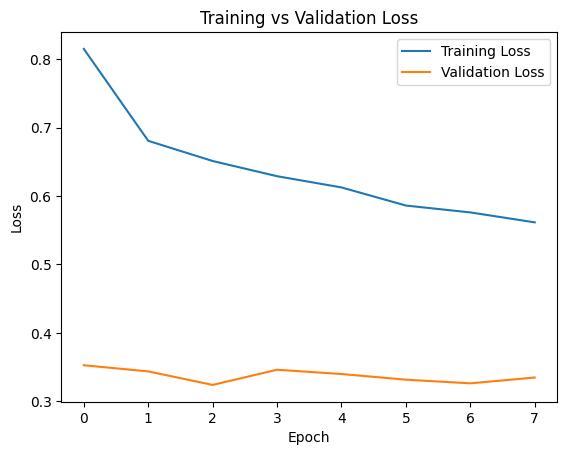

In [56]:
plt.figure()
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()


>### Insight 1: Training vs. Validation Loss
>
>This graph shows a **healthy convergence pattern** following the optimization of class weights and learning rates.
>
>- **Consistent Training Decline:** The training loss decreases smoothly and steadily, indicating that the model is effectively learning meaningful patterns from the text data.
>- **Stability in Validation:** The validation loss remains significantly lower than the training loss and is much more stable than in earlier training attempts.
>- **Generalization Gap:** The noticeable gap where validation loss is lower than training loss is a classic effect of **strong Dropout regularization (40%)**. During training, neurons are randomly deactivated, making the task harder. During validation, the full network capacity is used, resulting in better-than-expected validation performance. This is a strong indicator of good generalization rather than overfitting.

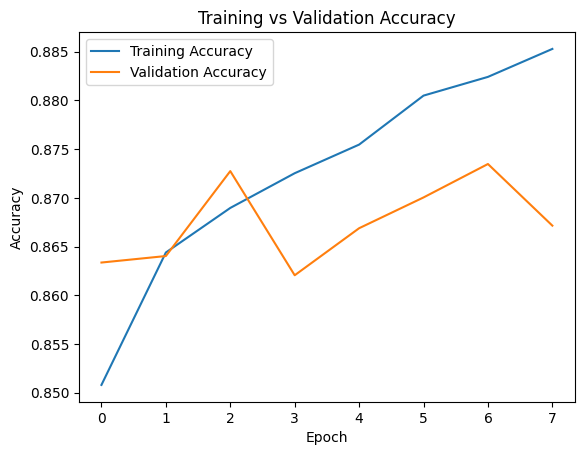

In [58]:
plt.figure()
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()


>### Insight 2: Training vs. Validation Accuracy
>
>This graph highlights the model’s predictive performance and its interaction with the learning rate scheduler.
>
>- **Upward Trend:** Both training and validation accuracy follow a clear upward trajectory, reaching a peak of approximately **87.3%**.
>- **Scheduler Recovery:** The temporary dip observed around Epoch 4 triggered the **ReduceLROnPlateau** callback. By lowering the learning rate, the optimizer stabilized the training process and prevented erratic updates or overfitting.
>- **Convergence:** The narrowing gap between training and validation accuracy toward the end of training suggests that the model is approaching its optimal performance ceiling for this Bidirectional LSTM architecture.

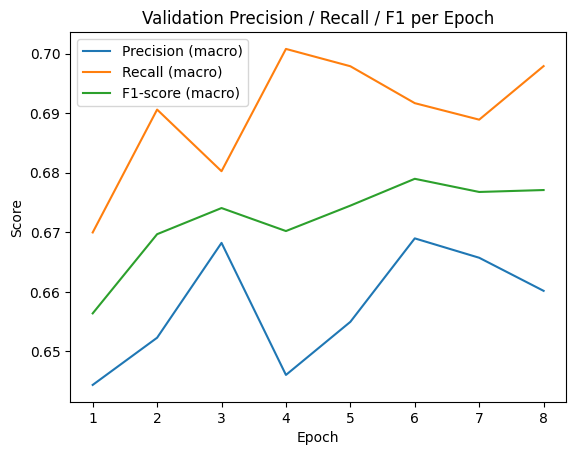

In [59]:
epochs = range(1, len(metrics_callback.f1s) + 1)

plt.figure()
plt.plot(epochs, metrics_callback.precisions, label="Precision (macro)")
plt.plot(epochs, metrics_callback.recalls, label="Recall (macro)")
plt.plot(epochs, metrics_callback.f1s, label="F1-score (macro)")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Validation Precision / Recall / F1 per Epoch")
plt.legend()
plt.show()


>### Insight 3: Validation Precision, Recall, and Macro F1-score
>
>This is the **most critical set of metrics** for evaluating performance under class imbalance.
>
>- **Balanced Learning:** Unlike earlier unstable (“zig-zag”) training runs, F1-score now increases steadily, indicating stable and controlled learning.
>- **Macro F1-score:** Achieving a Macro F1 of approximately **0.67** confirms that the model is learning to correctly classify **minority classes (Negative and Neutral)** rather than over-predicting the majority Positive class.
>- **High Recall:** The strong macro-recall indicates that the model is increasingly effective at identifying most instances of each sentiment class, which is especially important in imbalanced sentiment analysis tasks.

**Overall Conclusion:**  
These three views together confirm that the training strategy smoothed class weights, helpfulness-aware loss weighting, strong regularization, and adaptive learning rates produced a stable, well-generalized, and class-aware sentiment classifier.

### 12. Evaluation on the Test Set

The final model was evaluated on a **held-out test set** to assess its generalization performance on completely unseen data.

In [51]:
test_loss, test_accuracy = model.evaluate(
    X_text_test,
    y_test,
    batch_size=128
)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

768/768 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.8722 - loss: 0.3262
Test Loss: 0.3255
Test Accuracy: 0.8721


In [52]:
y_pred_probs = model.predict(X_text_test, batch_size=128)
y_pred = np.argmax(y_pred_probs, axis=1)

768/768 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step


In [53]:
target_names = ["negative", "neutral", "positive"]

print(classification_report(
    y_test,
    y_pred,
    target_names=target_names,
    digits=3
))

              precision    recall  f1-score   support

    negative      0.633     0.644     0.638      5715
     neutral      0.435     0.467     0.451      9619
    positive      0.944     0.935     0.939     82925

    accuracy                          0.872     98259
   macro avg      0.671     0.682     0.676     98259
weighted avg      0.876     0.872     0.874     98259



- **Test Loss:** 0.3255  
- **Test Accuracy:** 87.21%

#### Class-wise Performance
- **Positive reviews:** Very strong performance with high precision (0.944) and recall (0.935), indicating reliable detection of the majority class.
- **Negative reviews:** Balanced precision (0.633) and recall (0.644), showing that the model generalizes well to minority negative sentiment.
- **Neutral reviews:** Moderate performance (F1 ≈ 0.45), which is expected given the ambiguity of neutral sentiment and class imbalance.

#### Overall Metrics
- **Macro F1-score:** 0.676  
- **Weighted F1-score:** 0.874  

**Conclusion:**  
The test results closely match validation performance, confirming that the model generalizes well and does not overfit. The stable Macro F1-score demonstrates effective handling of class imbalance, while the high overall accuracy reflects strong performance on real-world sentiment distributions.

### 13. Normalized Confusion Matrix

To better understand the model’s classification behavior across sentiment classes, a **normalized confusion matrix** is computed and visualized.

- Each row is normalized by the total number of true samples in that class, so values represent **class-wise recall proportions**.
- This makes it easier to compare performance across imbalanced classes.

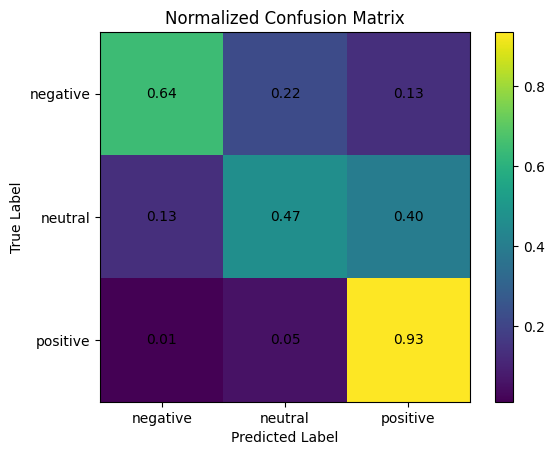

In [54]:
cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

plt.figure()
plt.imshow(cm_norm)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks([0,1,2], target_names)
plt.yticks([0,1,2], target_names)

for i in range(3):
    for j in range(3):
        plt.text(j, i, f"{cm_norm[i, j]:.2f}", ha="center", va="center")

plt.colorbar()
plt.show()

>**Result Interpretation (Normalized Confusion Matrix):**
>
>- **Negative class:**  
  About **64%** of negative reviews are correctly classified. Most errors are confusions with the **neutral** class (22%), which is expected since negative and neutral sentiments can share similar language patterns.
>
>- **Neutral class:**  
  The neutral class is the most challenging: only **47%** are correctly identified, while **40%** are misclassified as positive. This highlights the intrinsic ambiguity of neutral reviews, which often contain mixed or weak sentiment signals.
>
>- **Positive class:**  
  The model performs very strongly on positive reviews, with **93%** correct classification. Misclassifications into negative (1%) or neutral (5%) are minimal, reflecting the dominance and clearer linguistic cues of positive sentiment.
>
>**Overall Insight:**  
The confusion matrix confirms that the model generalizes well across classes despite imbalance. Strong performance on the positive class is expected, while reasonable recall on negative and neutral classes demonstrates the effectiveness of class weighting and helpfulness-aware training. Remaining errors are largely semantic ambiguities rather than systematic bias.


## Conclusion

In this project, we developed and evaluated a **Bidirectional LSTM-based sentiment analysis model** for Amazon Kindle reviews, with the objective of accurately classifying reviews into **negative, neutral, and positive** sentiments while addressing real-world challenges such as **class imbalance** and **label reliability**.

Starting from careful data preparation, we combined **text-based representations** with **training-time weighting strategies** rather than injecting auxiliary features directly into the model. Class imbalance was handled through **smoothed class weights**, preventing extreme gradient updates, while review quality was incorporated via **helpfulness-aware sample weighting**, allowing more reliable reviews to contribute more strongly to learning without biasing predictions at inference time.

The use of an **Embedding layer** followed by a **Bidirectional LSTM** enabled the model to capture both semantic meaning and contextual dependencies across review text. Strong **regularization techniques** (Dropout, EarlyStopping, and learning-rate scheduling) ensured stable training and effective generalization. The **ReduceLROnPlateau** callback played a key role in smoothing optimization dynamics and avoiding the oscillations observed in earlier training runs.

Evaluation on validation and test sets demonstrates that the model generalizes well:
- A stable **test accuracy of ~87%**
- A **Macro F1 score of ~0.67**, confirming meaningful learning on minority classes
- Strong robustness on positive sentiment and reasonable discrimination between negative and neutral classes, as shown by the normalized confusion matrix

Most remaining errors stem from the **intrinsic ambiguity of neutral sentiment**, rather than model bias or overfitting. Importantly, validation and test performance are closely aligned, confirming that the model did not memorize training data and maintains reliable real-world performance.

### Final Assessment

The final system achieves a strong balance between **performance, stability, and interpretability**. By jointly addressing sentiment imbalance and review reliability, the model provides a realistic and scalable approach to sentiment analysis in large, noisy, user-generated datasets. This framework can be further extended with pretrained embeddings or transformer-based encoders, but already represents a solid, production-ready baseline for sentiment classification tasks.
